# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Simão Sarmento"
SCIPER1 = 284660
student2 = "Dennis Gankin"
SCIPER2 = 284089

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [18]:
#%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io


import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization
from keras import backend as K

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(SCIPER1 + SCIPER2)
#np.random.seed(10)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

In [3]:
subset_of_classes

array([3, 0, 1, 7, 9])

### Plotting

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    #plt.close()
    #return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    #fig.tight_layout()
    plt.subplots_adjust(top=1.2)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    plt.close()
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_comparison(histories, optimizers, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    for idx, history in enumerate(histories):
        ax1.plot(history.history['loss'], label = "training "+ optimizers[idx])
        ax1.plot(history.history['val_loss'], label = "validation " + optimizers[idx])
        ax2.plot(history.history['acc'], label = "training "+optimizers[idx])
        ax2.plot(history.history['val_acc'], label = "validation "+optimizers[idx])
    plt.close()
    finalize_standardplot(fig, ax1, ax2)
    return fig

def box_plot(data, title, labels, model_labels):
    '''
    Function to plot a Box Plot
    :param data - List with loss and accuracy data ([0] and [1])
    :param title - Plot title
    :param labels - List with axis labels 
    :param model_labels - List with model labels
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
    fig.suptitle(title)
    # set labels
    ax1.set_xlabel(labels[0])
    ax2.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax2.set_ylabel(labels[2])
    # adjust size
    fig.subplots_adjust(wspace=0.3)
    # plotting...
    ax1.boxplot(data[0], labels = model_labels)
    ax2.boxplot(data[1], labels = model_labels)

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like this (or generally when prototyping), where we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [47]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    # normalization is performed
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.T, downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)

data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_original_all, x_train_all, y_train_all = preprocess(data_train)
x_test_original_all, x_test_all, y_test_all = preprocess(data_test)

### Shaping data as desired

In [48]:
img_rows = 16
img_cols = 16

if K.image_data_format() == 'channels_first':
    x_train_original_all = x_train_original_all.reshape(x_train_original_all.shape[0], 1, img_rows, img_cols)
    x_test_original_all = x_test_original_all.reshape(x_test_original_all.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_original_all = x_train_original_all.reshape(x_train_original_all.shape[0], img_rows, img_cols, 1)
    x_test_original_all = x_test_original_all.reshape(x_test_original_all.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
x_train_original_all = x_train_original_all.astype('float32')
x_test_original_all = x_test_original_all.astype('float32')
print('x_train_original_all shape:', x_train_original_all.shape)
print('x_test_original_all shape:', x_test_original_all.shape)

x_train_original_all shape: (73257, 16, 16, 1)
x_test_original_all shape: (26032, 16, 16, 1)


### Selecting a subset of classes

We further reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [49]:
def extract_classes(x_original, x_flat, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        #print('tmp : ', tmp)
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x_original[indices], x_flat[indices], labels

x_train_original, x_train, labels_train = extract_classes(x_train_original_all, x_train_all, y_train_all, subset_of_classes)
x_test_original, x_test, labels_test = extract_classes(x_test_original_all, x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

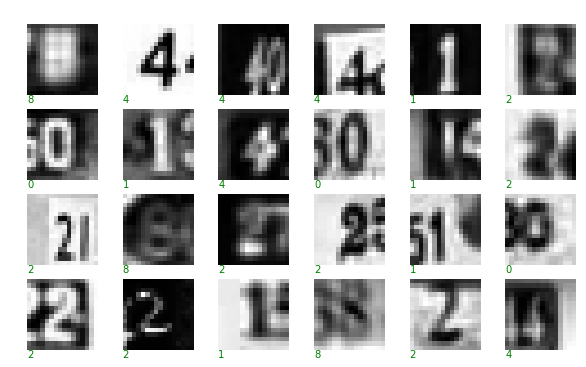

In [36]:
plot_some_samples(x_test, labels_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [37]:
y_train = keras.utils.to_categorical(labels_train)
y_test = keras.utils.to_categorical(labels_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

**Paramters Definition:**

In [65]:
activation_fct = 'softmax'
neurons = 5
loss_fct = 'categorical_crossentropy'
metrics = ['accuracy']
optimizer = 'SGD'
batch_size = 128
epochs = 500

**Create Model:**

In [66]:
def singlelayer_nn(activation_fct, input_dim, loss_fct, metrics, neurons, optimizer):
    '''
    :param activation_fct - activation function for output layer
    :param: input_dim - input dimension
    :param neurons - number of neurons for output layer
    :param loss_fct - loss function to use
    :param optimizer - type of optimizer
    :param metrics - measuring metrics
    '''
    # initialize sequential model
    model = Sequential()
    # add output layer
    model.add(Dense(neurons, input_dim = input_dim, activation=activation_fct))
    # compile model...
    model.compile(loss= loss_fct, optimizer=optimizer, metrics=metrics)
    # print summary
    model.summary()
    
    return model

In [67]:
# creating model
model = singlelayer_nn(activation_fct, 256, loss_fct, metrics, neurons, optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________


**Fitting:**

In [68]:
# starting...
start = time.time()
# fitting...
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data = (x_test, y_test),
                    verbose=0)
# the end
end = time.time()

print('Model take %0.2f seconds to train'%(end-start))

Model take 55.60 seconds to train


**Check performance:**

In [69]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.502229045336879
Test accuracy: 0.39301482702106777


**Fitting Procedure Plot**

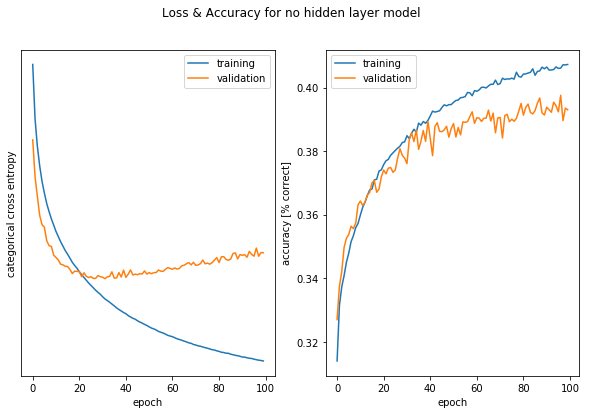

In [78]:
plot_history(history, 'Loss & Accuracy for no hidden layer model')

In the figure above we can clearly observe what is called the elbow effect, given the shape of the validation loss curve. 

**Misclassified**

Predictions are calculated as follows:

In [18]:
yhat_test = model.predict(x_test)

Detecting error indices...

In [19]:
labels_hat = np.asarray([np.argmax(yhat_test[i]) for i in range(len(yhat_test))])
labels_test = np.asarray([np.argmax(y_test[i]) for i in range(len(y_test))])

error_indices = np.where(labels_hat != labels_test)[0]

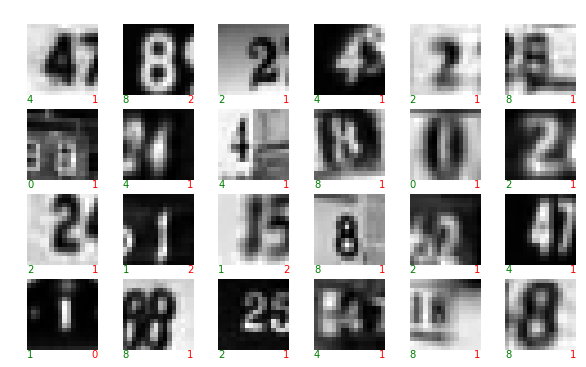

In [22]:
plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

**Paramters Definition:**

In [23]:
activation_per_layer = ['relu','softmax']
neurons_per_layer = [64,5]
loss_fct = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 128
epochs = 50

**Create Model:**

In [63]:
def hiddenlayer_nn(activation_per_layer, input_dim, loss_fct, metrics, neurons_per_layer, optimizer):
    '''
    :param: input_dim - input dimension
    :param neurons_per_layer - list of neurons in each layer
    :param activation_per_layer - list of activation functions in each layer
    :param loss_fct - loss function to use
    :param optimizer - type of optimizer
    :param metrics - measuring metrics
    '''
    # initialize sequential model
    model = Sequential()
    # fill layers (different for first layer -> need to specify input dim)
    for i in range(len(neurons_per_layer)):
        if i == 0:
            model.add(Dense(neurons_per_layer[i], input_dim = input_dim, activation=activation_per_layer[i]))
        else:
            model.add(Dense(neurons_per_layer[i], activation = activation_per_layer[i]))
    # complile model
    model.compile(loss= loss_fct, optimizer=optimizer, metrics=metrics)
    # print summary
    model.summary()
    
    return model

**Testing SGD w/ different learning rates:**

In [25]:
learning_rates = [0.001, 0.1, 10]
history_sgd = []
for lr in learning_rates:
    # define sgd optimizer with specific learning rate
    sgd = SGD(lr = lr)
    # create model
    model = hiddenlayer_nn(activation_per_layer, 256, loss_fct, metrics, neurons_per_layer, sgd)
    # fit model
    history = model.fit(np.asarray(x_train), y_train,
                        validation_data = (x_test, y_test),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0)
    # test model
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss for lr = {}: {}'.format(lr, score[0]))
    print('Test accuracy for lr = {}: {}'.format(lr, score[1])) 
    
    history_sgd.append(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss for lr = 0.001: 1.4603075871632558
Test accuracy for lr = 0.001: 0.3846457990115321
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
________________________________________

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) For larger learning rates, the step per itaration is excessively big, and it jumps over the minima we are trying to reach, ie. we overshoot, and the minimium might not ever be reached (divergence).

B) For a smaller learning rate, less information is learned per epoch. Thus, more epochs are required in order to learn a good model, for this specific dataset, 0.001 shows to be a too small learning rate. 

**Testing Adam Optimizer**

In [26]:
# create model
model = hiddenlayer_nn(activation_per_layer, 256, loss_fct, metrics, neurons_per_layer, 'adam')
# fit model
history_adam = model.fit(np.asarray(x_train), y_train,
                         validation_data = (x_test, y_test),
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=0)
# test model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss for Adam Optimizer: {}'.format(score[0]))
print('Test accuracy for Adam Optimizer: {}'.format(score[1]))    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss for Adam Optimizer: 0.504039209356418
Test accuracy for Adam Optimizer: 0.8682701812230382


**Plotting...**

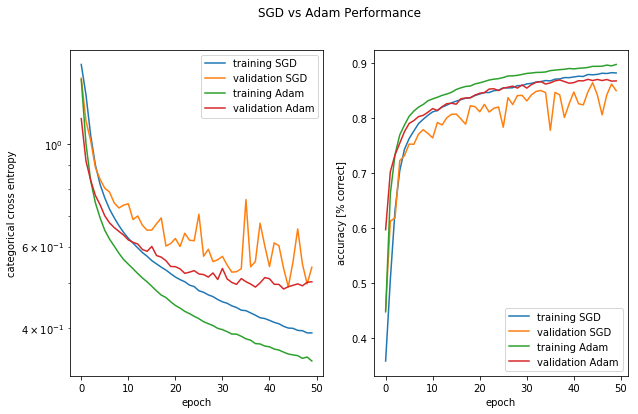

In [27]:
plot_comparison([history_sgd[1], history_adam], ['SGD', 'Adam'], 'SGD vs Adam Performance')

# WHY IS VALIDATION SGD SO UNSTABLE??

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

**Parameters Definition:**

In [270]:
activation_per_layer = ['relu','softmax']
neurons_per_layer = [64,5]
loss_fct = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 128
epochs = 500
optimizer = 'adam'

**Training...**

In [273]:
# create model
model = hiddenlayer_nn(activation_per_layer, 256, loss_fct, metrics, neurons_per_layer, optimizer)
# fit model
history_overfitted = model.fit(np.asarray(x_train), y_train,
                               validation_data = (x_test, y_test),
                               batch_size=batch_size,
                               epochs=epochs,
                               verbose=0)
# test model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss for Adam Optimizer: {}'.format(score[0]))
print('Test accuracy for Adam Optimizer: {}'.format(score[1]))  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss for Adam Optimizer: 0.66598051196268
Test accuracy for Adam Optimizer: 0.8810543657409693


**Plotting...**

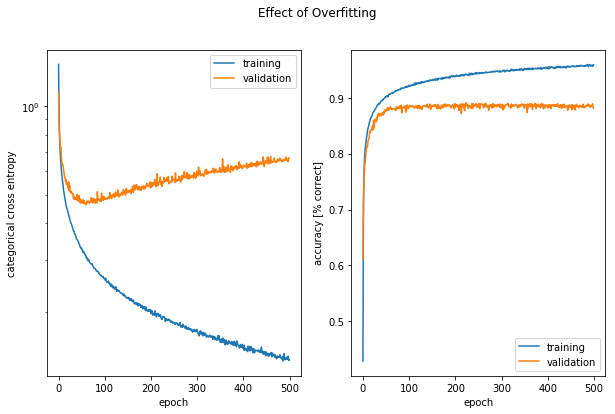

In [274]:
plot_history(history_overfitted, 'Effect of Overfitting')

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: The model starts to overfit after approximately 70 epochs, when the categorial cross entropy of the validation data starts to rise again.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: One can notice that the accuracy of the training data augments and converges to 1 while for the validation data it rises to a certain point and then stays at a constant level when the model is overfitting. The loss is reduced with more epochs and the training data converges to 0 while the loss on the validation set reaches a minimum and then starts rising again when the model starts overfitting. While accuracy stays constant when overfitting the loss gets bigger again from the point when overfitting starts, which proves the need for "early stopping".

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depend on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

**Parameters Definition:**

In [128]:
activation_per_layer = ['relu','softmax']
neurons_per_layer = [[10,5], [100, 5],[500, 5], [1000, 5]]
loss_fct = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 128
epochs = 500
optimizer = 'adam'
n_initial_conditions = 5

**Fitting for different number of hidden neurons...**

Initialize storage lists:

In [129]:
# array to store loss and acc values
loss_per_model = []
acc_per_model = []

# array to store loss and acc values with early stopping
loss_per_model_es = []
acc_per_model_es = []

# array to store one history per model, for plot purposes
histories = []

In [130]:
for neurons in neurons_per_layer:
    # inner loop for different initial conditions
    # -- seed is not resetted
    # -- each time a model is initializated, we get different initial conditions
    # no early stopping
    loss_per_init = []
    acc_per_init = []
    # with early stopping
    loss_per_init_es = []
    acc_per_init_es = []
    for initial_i in range(n_initial_conditions):
        # create model
        model = hiddenlayer_nn(activation_per_layer, 256, loss_fct, metrics, neurons, 'adam')
        # fit model
        history = model.fit(np.asarray(x_train), y_train,
                            validation_data = (x_test, y_test),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0)
        
        # store loss and accuracy without early stopping
        loss_per_init.append(history.history['val_loss'][-1])
        acc_per_init.append(history.history['val_acc'][-1])
        
        # get minimium loss index
        es_idx = history.history['val_loss'].index(min(history.history['val_loss']))
        # store loss and accuracy with early stopping
        loss_per_init_es.append(history.history['val_loss'][es_idx])
        acc_per_init_es.append(history.history['val_acc'][es_idx])
        
    # append one history object per model - for plotting purposes
    histories.append(history)
    
    # append loss and accuracy values to use for Box Plot:
    # -- with early stopping -- 
    loss_per_model_es.append(loss_per_init_es)
    acc_per_model_es.append(acc_per_init_es)
    # --without early stopping--
    loss_per_model.append(loss_per_init)
    acc_per_model.append(acc_per_init)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 10)                2570      
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 55        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 10)                2570      
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 55        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 500)               128500    
_________________________________________________________________
dense_50 (Dense)             (None, 5)                 2505      
Total params: 131,005
Trainable params: 131,005
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 1000)              257000    
_________________________________________________________________
dense_52 (Dense)             (None, 5)                 5005      
Total params: 262,005
Trainable params: 262,005
Non-trainable params: 0
_________________________________________________________________
________________________________________________________________

**Box Plotting**

We express the variability due to different initial conditions with the following Box Plots:

*Box plot without early stopping*

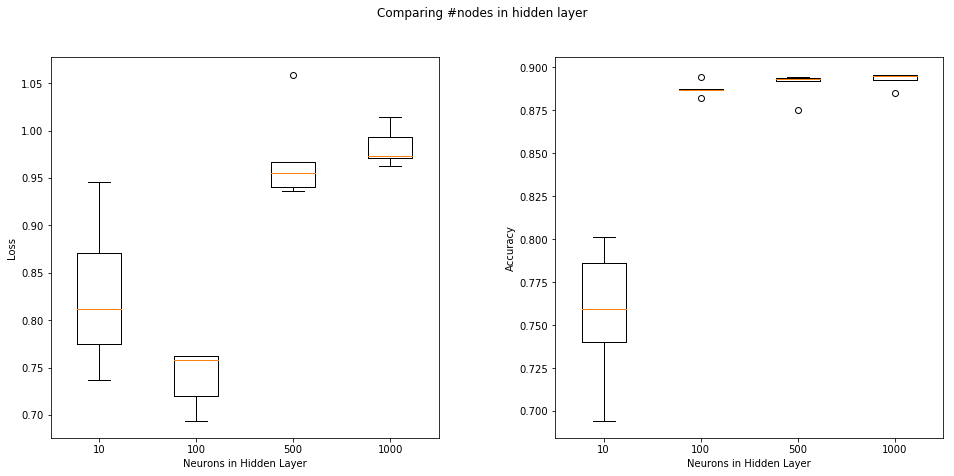

In [132]:
box_plot([loss_per_model, acc_per_model], 'Comparing #nodes in hidden layer',
         ['Neurons in Hidden Layer','Loss', 'Accuracy'], ['10', '100', '500','1000'])

*Box plot with early stopping*

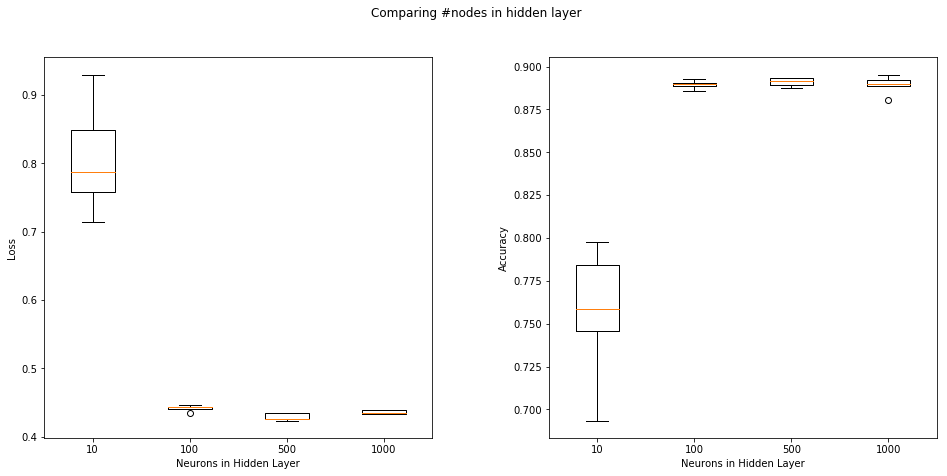

In [133]:
box_plot([loss_per_model_es, acc_per_model_es], 'Comparing #nodes in hidden layer',
         ['Neurons in Hidden Layer','Loss', 'Accuracy'], ['10', '100', '500','1000'])

**Plotting for different number of hidden nodes**

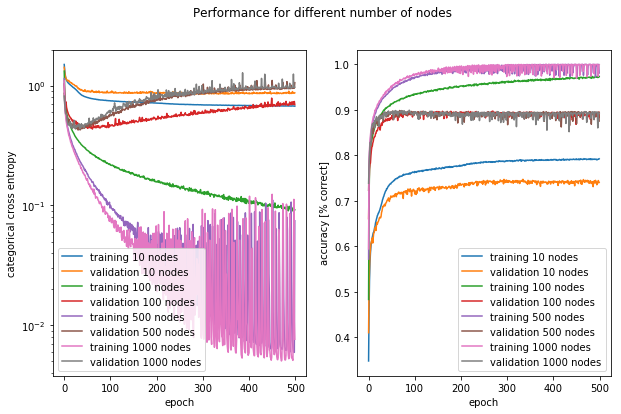

In [134]:
plot_comparison(histories, ['10 nodes', '100 nodes', '500 nodes','1000 nodes'], 'Performance for different number of nodes')

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

If we assume that each layer has the same amount of neurons.

***number of parameters*** $ = (N_{in}+1)\cdot N_h + (K-1)\cdot (N_h+1)\cdot N_h + (N_h+1)\cdot N_{out}$

Therefore, for $ N_{in} = 256, N_h =100, K = 1, N_{out} = 5$, we get **26205 parameters**.

Thus:

K=2:  N_h = 77

K=3:  N_h = 66

K=4   N_h = 59

In [143]:
activation_per_layer = [['relu','relu','softmax'],['relu','relu','relu','softmax'],
                        ['relu','relu','relu','relu','softmax']]
neurons_per_layer = [[77,77,5], [66,66,66,5], [59,59,59,59, 5]]
loss_fct = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 128
epochs = 500
optimizer = 'adam'
n_initial_conditions = 5

Initialize storage lists...

In [144]:
# array to store loss and acc values with early stopping
loss_per_model_es = []
acc_per_model_es = []

# array to store one history per model, for plot purposes
histories = []

In [145]:
for i,neurons in enumerate(neurons_per_layer):
    # inner loop for different initial conditions
    # -- seed is not resetted
    # -- each time a model is initializated, we get different initial conditions
    # with early stopping
    loss_per_init_es = []
    acc_per_init_es = []
    for initial_i in range(n_initial_conditions):
        # create model
        model = hiddenlayer_nn(activation_per_layer[i], 256, loss_fct, metrics, neurons, 'adam')
        # fit model
        history = model.fit(np.asarray(x_train), y_train,
                            validation_data = (x_test, y_test),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0)
        
        # get minimium loss index
        es_idx = history.history['val_loss'].index(min(history.history['val_loss']))
        # store loss and accuracy with early stopping
        loss_per_init_es.append(history.history['val_loss'][es_idx])
        acc_per_init_es.append(history.history['val_acc'][es_idx])

    # append one history object per model - for plotting purposes
    histories.append(history)
    
    # append loss and accuracy values to use for Box Plot:
    # -- with early stopping -- 
    loss_per_model_es.append(loss_per_init_es)
    acc_per_model_es.append(acc_per_init_es)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 77)                19789     
_________________________________________________________________
dense_66 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_67 (Dense)             (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 77)                19789     
_________________________________________________________________
dense_69 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 59)                15163     
_________________________________________________________________
dense_106 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_107 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_108 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_109 (Dense)            (None, 5)                 300       
Total params: 26,083
Trainable params: 26,083
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_

**Box Plotting**

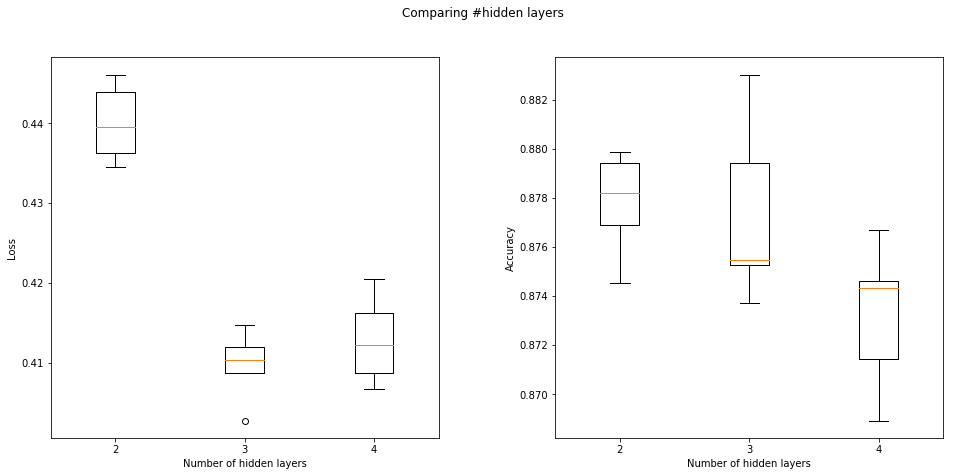

In [146]:
box_plot([loss_per_model_es, acc_per_model_es], 'Comparing #hidden layers',
         ['Number of hidden layers','Loss', 'Accuracy'], ['2', '3', '4'])

In [ ]:
plot_comparison(histories, ['2 layers', '3 layers', '4 layers'], 'Performance for different number of hidden layers')

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

**Basic Parameters:**

In [60]:
def build_regularized_nn(input_dim, neurons_per_layer, activation_per_layer,
                         batch_normalization, dropout_per_layer , l1_regularizer = 0, l2_regularizer = 0):
    '''
    Function to build neural net performing
    regularization at different levels.
    :param: input_dim - input dimension
    :param neurons_per_layer - list of neurons in each layer
    :param activation_per_layer - list of activation functions in each layer
    :param batch_normalization - boolean that indicates whether to perform batch_normalization or not
    :param dropout_per_layer - dropout probability per layer
    :param l1_regularizer - value for l1 regularizer
    :param l2_regularizer - value for l2 regularizer
    '''
    # define basic parameters
    batch_size = 128; epochs = 250; optimizer = 'adam'; 
    loss_fct = 'categorical_crossentropy'; metrics = ['accuracy']
    
    # initialize sequential model
    model = Sequential()
    # fill layers (different for first layer -> need to specify input dim)
    for layer in range(len(neurons_per_layer)):
        if layer == 0:
            model.add(Dense(neurons_per_layer[layer], input_dim = input_dim, activation=activation_per_layer[layer]))
            if batch_normalization:
                model.add(BatchNormalization())
                print('Added Batch Normalization')
            model.add(Dropout(dropout_per_layer[layer]))
        else:
            model.add(Dense(neurons_per_layer[layer], activation = activation_per_layer[layer]))
            if batch_normalization:
                model.add(BatchNormalization())
                print('Added Batch Normalization')
            # add dropout except for output layer
            if layer != (len(neurons_per_layer) - 1):
                model.add(Dropout(dropout_per_layer[layer]))
                print('Dropout added in layer ', layer)
            
    # complile model
    model.compile(loss= loss_fct, optimizer=optimizer, metrics=metrics)
    
    # fitting
    history = model.fit(np.asarray(x_train), y_train,
                            validation_data = (x_test, y_test),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0)
        
    # get minimium loss index
    es_idx = history.history['val_loss'].index(min(history.history['val_loss']))
    # store loss and accuracy with early stopping
    loss = history.history['val_loss'][es_idx]
    acc = history.history['val_acc'][es_idx]
    
    
    return history, loss, acc

**`Batch Normalization`:**

At this point, is not obvious where to apply the batch normalization: while the authors of batch normalisation suggest performing it before applying the activation function of the neuron (on the computed linear combinations of the input data), [recently published results](https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md) suggest that it might be more beneficial (and at least as good) to do it after. For this reason, we will follow on with the second approach.

**`Dropout layers`:**

For our dropout, we will base our tuning at this [paper](http://jmlr.org/papers/v15/srivastava14a.html). Several common tips to improve the performance are explored. In short, we will take this into account:
- Use small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.
- Use dropout on incoming (visible) as well as hidden units. Application of dropout at each layer of the network has shown good results.
- Constrain the size of network weights. A large learning rate can result in very large network weights. Imposing a constraint on the size of network weights such as max-norm regularization with a size of 4 or 5 has been shown to improve results. For this purpose, tha application of the l2-regulizer will prove to be useful.

**`L1 regularization`:**

**`L2 regularization`:**

**Start tunning...**

Define storage variables...

In [77]:
'''
** Nomencature **
K1_N100 - 1 hidden layer, 100 Nodes
K4_N59 - 4 hidden layers, 59 Nodes each
'''
K1_N100 = []
K4_N59 = []

# 1. Batch Normalization
K1_N100.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                                    batch_normalization = True, dropout_per_layer = [0,0]))

#K4_N59.append()

# 2. Dropout (0.2)
K1_N100.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                                    batch_normalization = False, dropout_per_layer = [0.2,0.2])) 
#K4_N59.append()

# 3. Dropout (0.5)
K1_N100.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                                    batch_normalization = False, dropout_per_layer = [0.5,0.5])) 
#K4_N59.append()

# 4. l1 regularizer
#K1_N100.append() 
#K4_N59.append()

# 5. l2 regularizer
#K1_N100.append() 
#K4_N59.append()

# ------- Start composing regularizers -------

# 6. Batch Normalization + Dropout(0.2)

# 7. Batch Normalization + Dropout(0.5)

# 7. Batch Normalization + Dropout(0.2) + l1 regularizer

# 8. Batch Normalization + Dropout(0.2) + l2 regularizer

# 9. Batch Normalization + Dropout(0.2) + l1 regularizer + l2 regularizer

**Comparison:**

Loss:  1.191466800180652
Accuracy:  0.5592092257315873


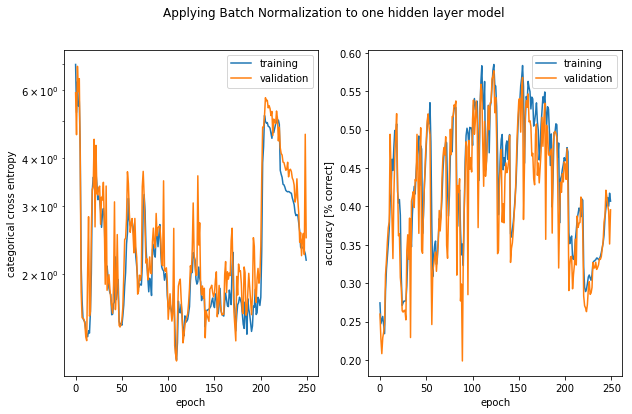

In [82]:
print('Validation loss (best): ', K1_N100[0][1])
print('Validtion accuracy: ', K1_N100[0][2])
plot_history(K1_N100[0][0], 'Applying Batch Normalization to one hidden layer model')

Loss:  0.43060667704514655
Accuracy:  0.8953542009334784


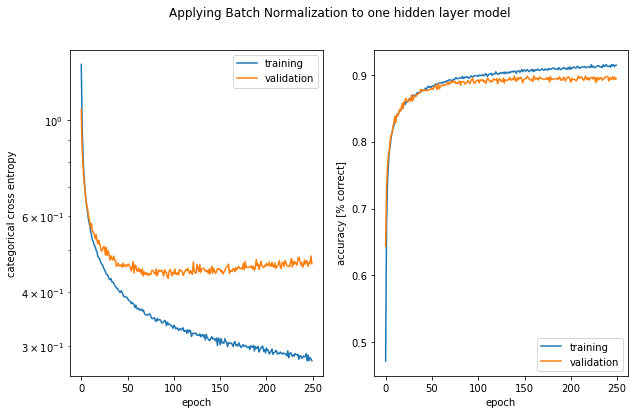

In [83]:
print('Validation loss (best): ', K1_N100[1][1])
print('Validtion accuracy: ', K1_N100[1][2])
plot_history(K1_N100[1][0], 'Applying DropOut to one hidden layer model with p = 0.2')

Loss:  0.4756575184049088
Accuracy:  0.8753871499372667


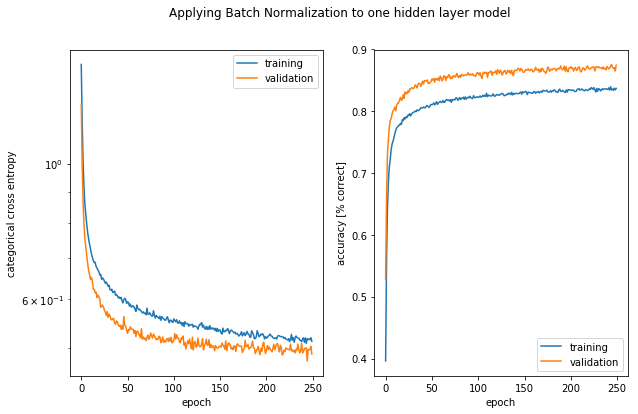

In [84]:
print('Validation loss (best): ', K1_N100[2][1])
print('Validtion accuracy: ', K1_N100[2][2])
plot_history(K1_N100[2][0], 'Applying DropOut to one hidden layer model with p = 0.5'')

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

**Convolution neural nets** are composed by two main stages. The 1st one corresponds to the `convolution` and `pooling`, whereas the second stage corresponds to input the obtained result in a fully connected neural network, as considered above.

Note that for the first stage, the data must be inputted in the original format and not as a 1-D array. 

To deal with overfitting, we will use dropout. As pooling layer we will use a common choice that usualy leads to good results, `max-pooling`, where the maximum pixel value within a chunk is taken.

**Define parameters:**

In [52]:
batch_size = 32 # in each iteration, we consider 32 training examples at once
num_epochs = 200 # we iterate 200 times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 128 neurons

# we must input the data in its original shape, therefore:
x_train = x_train_original
x_test = x_test_original

**For this exercise, we will consider two distinct configurations, and take the best one:**

**Configuration 1**

In [53]:
# 1st Stage
model = Sequential()
model.add(Conv2D(conv_depth_1, kernel_size=(kernel_size, kernel_size),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(conv_depth_2, (kernel_size, kernel_size), activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))

# 2nd Stage
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 41897 samples, validate on 15175 samples
Epoch 1/200
41897/41897 [==============================] - 33s 799us/step - loss: 0.6121 - acc: 0.7894 - val_loss: 0.3059 - val_acc: 0.9116
Epoch 2/200
41897/41897 [==============================] - 39s 921us/step - loss: 0.3218 - acc: 0.9014 - val_loss: 0.2596 - val_acc: 0.9245
Epoch 3/200
41897/41897 [==============================] - 35s 843us/step - loss: 0.2782 - acc: 0.9156 - val_loss: 0.2297 - val_acc: 0.9324
Epoch 4/200
41897/41897 [==============================] - 34s 807us/step - loss: 0.2564 - acc: 0.9223 - val_loss: 0.2196 - val_acc: 0.9347
Epoch 5/200
41897/41897 [==============================] - 34s 822us/step - loss: 0.2358 - acc: 0.9274 - val_loss: 0.2171 - val_acc: 0.9356
Epoch 6/200
41897/41897 [==============================] - 34s 805us/step - loss: 0.2196 - acc: 0.9325 - val_loss: 0.2106 - val_acc: 0.9396
Epoch 7/200
41897/41897 [==============================] - 33s 795us/step - loss: 0.2091 - acc: 0.9359 - val_l

41897/41897 [==============================] - 26s 610us/step - loss: 0.0837 - acc: 0.9727 - val_loss: 0.1973 - val_acc: 0.9578
Epoch 59/200
41897/41897 [==============================] - 26s 610us/step - loss: 0.0851 - acc: 0.9719 - val_loss: 0.1941 - val_acc: 0.9570
Epoch 60/200
41897/41897 [==============================] - 26s 617us/step - loss: 0.0824 - acc: 0.9734 - val_loss: 0.1927 - val_acc: 0.9572
Epoch 61/200
41897/41897 [==============================] - 26s 611us/step - loss: 0.0834 - acc: 0.9727 - val_loss: 0.1893 - val_acc: 0.9580
Epoch 62/200
41897/41897 [==============================] - 26s 615us/step - loss: 0.0821 - acc: 0.9721 - val_loss: 0.1911 - val_acc: 0.9574
Epoch 63/200
41897/41897 [==============================] - 26s 614us/step - loss: 0.0815 - acc: 0.9731 - val_loss: 0.1851 - val_acc: 0.9564
Epoch 64/200
41897/41897 [==============================] - 27s 652us/step - loss: 0.0833 - acc: 0.9732 - val_loss: 0.1914 - val_acc: 0.9566
Epoch 65/200
41897/41897 [

41897/41897 [==============================] - 29s 698us/step - loss: 0.0664 - acc: 0.9787 - val_loss: 0.2229 - val_acc: 0.9574
Epoch 117/200
41897/41897 [==============================] - 29s 703us/step - loss: 0.0628 - acc: 0.9798 - val_loss: 0.2192 - val_acc: 0.9588
Epoch 118/200
41897/41897 [==============================] - 32s 760us/step - loss: 0.0666 - acc: 0.9788 - val_loss: 0.2241 - val_acc: 0.9580
Epoch 119/200
41897/41897 [==============================] - 29s 693us/step - loss: 0.0626 - acc: 0.9798 - val_loss: 0.2262 - val_acc: 0.9584
Epoch 120/200
41897/41897 [==============================] - 27s 648us/step - loss: 0.0622 - acc: 0.9805 - val_loss: 0.2232 - val_acc: 0.9587
Epoch 121/200
41897/41897 [==============================] - 26s 627us/step - loss: 0.0668 - acc: 0.9782 - val_loss: 0.2113 - val_acc: 0.9575
Epoch 122/200
41897/41897 [==============================] - 38s 918us/step - loss: 0.0618 - acc: 0.9798 - val_loss: 0.2074 - val_acc: 0.9582
Epoch 123/200
41897/

Epoch 174/200
41897/41897 [==============================] - 25s 604us/step - loss: 0.0562 - acc: 0.9820 - val_loss: 0.2406 - val_acc: 0.9564
Epoch 175/200
41897/41897 [==============================] - 26s 626us/step - loss: 0.0535 - acc: 0.9838 - val_loss: 0.2211 - val_acc: 0.9569
Epoch 176/200
41897/41897 [==============================] - 27s 654us/step - loss: 0.0549 - acc: 0.9822 - val_loss: 0.2187 - val_acc: 0.9584
Epoch 177/200
41897/41897 [==============================] - 26s 632us/step - loss: 0.0554 - acc: 0.9822 - val_loss: 0.2123 - val_acc: 0.9578
Epoch 178/200
41897/41897 [==============================] - 30s 720us/step - loss: 0.0596 - acc: 0.9814 - val_loss: 0.2221 - val_acc: 0.9582
Epoch 179/200
41897/41897 [==============================] - 28s 662us/step - loss: 0.0602 - acc: 0.9816 - val_loss: 0.2158 - val_acc: 0.9580
Epoch 180/200
41897/41897 [==============================] - 29s 681us/step - loss: 0.0555 - acc: 0.9822 - val_loss: 0.2161 - val_acc: 0.9589
Epoch 

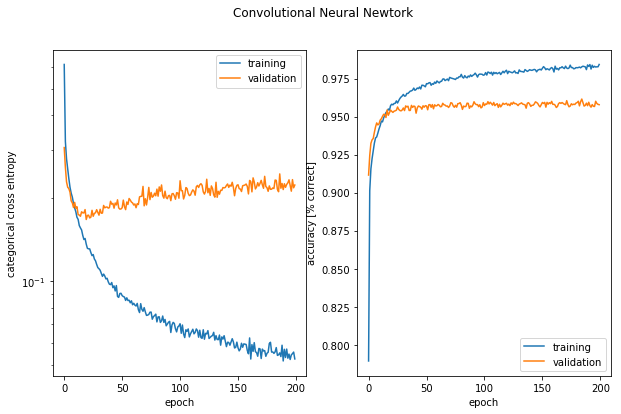

In [54]:
plot_history(history, 'Convolutional Neural Newtork')

Value with early stop:

In [55]:
# get minimium loss index
es_idx = history.history['val_loss'].index(min(history.history['val_loss']))
# store loss and accuracy with early stopping
loss = history.history['val_loss'][es_idx]
acc = history.history['val_acc'][es_idx]

print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.16778840308797222
Test accuracy: 0.9542668863261944


**Configuration 2**

In [ ]:
# 1st Stage
model = Sequential()
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
model.add(Conv2D(conv_depth_1, kernel_size=(kernel_size, kernel_size),
                 activation='relu', padding='same',
                 input_shape=input_shape))
model.add(Conv2D(conv_depth_1, (kernel_size, kernel_size), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
model.add(Conv2D(conv_depth_2, (kernel_size, kernel_size), padding='same',activation='relu'))
model.add(Conv2D(conv_depth_2, (kernel_size, kernel_size), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))

# 2nd Stage
model.add(Flatten())
model.add(Dense(hidden_size, activation='relu'))
model.add(Dropout(drop_prob_2))
model.add(Dense(5, activation='softmax'))

# compile
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# fit
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])